# sup9A

In [ ]:
import gseapy as gp
from gseapy import dotplot
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import omicverse as ov
#import scvelo as scv
import anndata as ad
#from pyslingshot import Slingshot

In [3]:
rna=sc.read_h5ad('/data1/fengyu/methods/scRNA/LUAD_GSE148071/luad_forcellbin.h5ad')

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


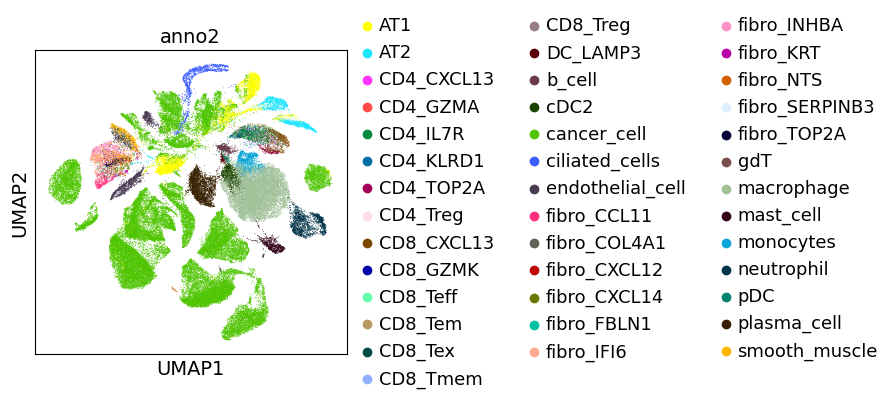

In [4]:
sc.pl.umap(rna, color='anno2', save = 'Sup10A1.pdf')

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


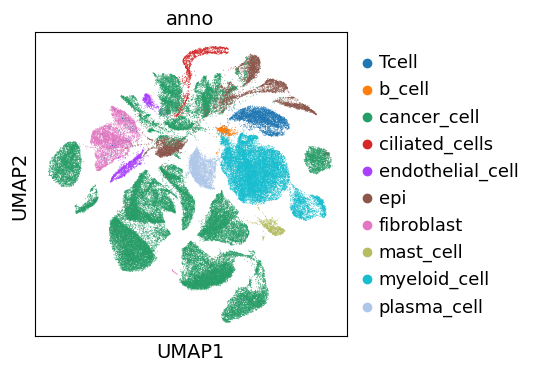

In [5]:
sc.pl.umap(rna, color='anno', save = 'Sup10A2.pdf')

# sup9B&C

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


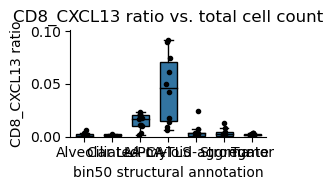

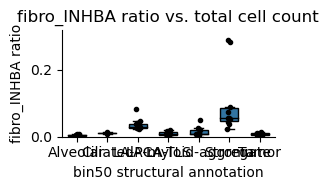

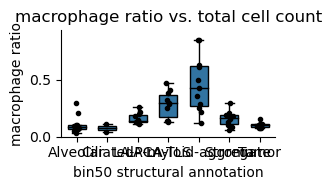

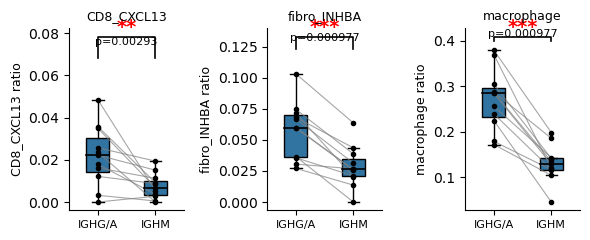

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats

# ---------- 数据准备 ----------
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
meta = pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv', index_col=0)
adata.obs['loc'] = adata.obs['batch'].astype(str) + '_' + adata.obs['bin50_x'].map(str) + '_' + adata.obs['bin50_y'].map(str)
adata.obs = adata.obs.merge(meta[['loc', 'LA_anno']], on='loc', how='left')
adata.obs_names = adata.obs_names.astype(str)
df = adata.obs  # 便于下方操作

# ---------- Sup10B1-3: 每region类型细胞比例 boxplot 含点 ----------
names = ['CD8_CXCL13', 'fibro_INHBA', 'macrophage']
for idx, cell_type in enumerate(names, start=1):
    # 统计
    total = df.groupby(['batch', 'bin50 structural annotation']).size().rename('total_cell')
    cell_cnt = (
        df[df['anno2'] == cell_type]
        .groupby(['batch', 'bin50 structural annotation'])
        .size()
        .rename('cell_cnt')
    )
    plot_df = (
        pd.concat([total, cell_cnt], axis=1)
          .assign(ratio=lambda x: x['cell_cnt'] / x['total_cell'])
          .reset_index()
          .dropna(subset=['ratio'])
    )
    fig, ax = plt.subplots(figsize=(3, 2))
    grouped = plot_df.groupby('bin50 structural annotation')['ratio']
    box_data = [g.values for _, g in grouped]
    labels   = list(grouped.groups.keys())
    bp = ax.boxplot(
        box_data,
        positions=range(len(labels)),
        widths=0.6,
        patch_artist=True,
        showfliers=False
    )
    for patch in bp['boxes']:
        patch.set_facecolor('#3274A1')
        patch.set_edgecolor('black')
    for med in bp['medians']:
        med.set_color('black')
    for whisk in bp['whiskers']:
        whisk.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')
    # stripplot
    for pos, vec in zip(range(len(labels)), box_data):
        jitter = pos + np.random.normal(0, 0.04, len(vec))
        ax.scatter(jitter, vec, color='black', s=9, zorder=3)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel('bin50 structural annotation')
    ax.set_ylabel(f'{cell_type} ratio')
    ax.set_title(f'{cell_type} ratio vs. total cell count')
    ax.set_ylim(0, plot_df['ratio'].max() * 1.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    plt.grid(False)
    fig.savefig(f'Sup10B{idx}.pdf', bbox_inches='tight')
    plt.show()

# ---------- Sup10D1-3: IGHG/A vs IGHM 配对 Wilcoxon ----------
anno2_list = ['CD8_CXCL13', 'fibro_INHBA', 'macrophage']
total = df.groupby(['batch', 'LA_anno']).size().rename('total_cell')

with PdfPages('Sup10D1-4.pdf') as pdf:
    fig, axes = plt.subplots(1, 3, figsize=(6, 2.5), sharey=False)
    for idx, cell_type in enumerate(anno2_list):
        cls_cnt = (
            df[df['anno2'] == cell_type]
            .groupby(['batch', 'LA_anno'])
            .size()
            .rename('cls_cnt')
        )
        plot_df = (
            pd.concat([total, cls_cnt], axis=1)
              .assign(cls_ratio=lambda x: x['cls_cnt'] / x['total_cell'])
              .reset_index()
        )
        plot_df = plot_df[plot_df['LA_anno'].isin(['PCA_IGHG/A', 'PCA_IGHM'])]
        # 配对准备
        pivot_df = plot_df.pivot(index='batch', columns='LA_anno', values='cls_ratio').dropna(subset=['PCA_IGHG/A', 'PCA_IGHM'])
        group1 = pivot_df['PCA_IGHM']
        group2 = pivot_df['PCA_IGHG/A']
        stat, p_val = stats.wilcoxon(group1, group2)
        ax = axes[idx]
        x_pos = np.arange(2)
        labels = ['IGHG/A', 'IGHM']
        box_data = [group2.values, group1.values]
        bp = ax.boxplot(box_data,
                        positions=x_pos,
                        widths=0.4,
                        patch_artist=True,
                        showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor('#3274A1')
            patch.set_edgecolor('black')
            patch.set_linewidth(1)
        for whisk in bp['whiskers']:
            whisk.set_color('black')
            whisk.set_linewidth(1)
        for cap in bp['caps']:
            cap.set_color('black')
            cap.set_linewidth(1)
        for med in bp['medians']:
            med.set_color('black')
            med.set_linewidth(1.2)
        # Paired dots and lines
        for i, (v1, v2) in enumerate(zip(group2.values, group1.values)):
            ax.plot([x_pos[0], x_pos[1]], [v1, v2], color='grey', lw=0.8, alpha=0.7, zorder=2)
            ax.scatter([x_pos[0]], [v1], color='black', s=9, zorder=3)
            ax.scatter([x_pos[1]], [v2], color='black', s=9, zorder=3)
        # Annotation
        y_max = np.max([group1.max(), group2.max()])
        bar_height = y_max + 0.02
        x1, x2 = x_pos[0], x_pos[1]
        ax.plot([x1, x1, x2, x2],
                [bar_height, bar_height + 0.01, bar_height + 0.01, bar_height],
                lw=1.2, c='black')
        ax.text((x1 + x2) / 2, bar_height + 0.005, f'p={p_val:.3g}',
                ha='center', va='bottom', fontsize=8)
        # 显著性星号
        if p_val < 0.001:
            signif = '***'
        elif p_val < 0.01:
            signif = '**'
        elif p_val < 0.05:
            signif = '*'
        else:
            signif = ''
        if signif:
            ax.text((x1 + x2) / 2, bar_height + 0.01, signif,
                    ha='center', va='bottom', color='red', fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['IGHG/A', 'IGHM'], fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel(f'{cell_type} ratio', fontsize=9)
        ax.set_title(cell_type, fontsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
    plt.tight_layout()
    #pdf.savefig(fig)
    plt.show()